## Module 3 project - Ravi Dahiya & Khairul Omar
### Crime statistics around Moorgate in London

### Table of contents
1. Executive summary
2. Data import and data cleansing  
    - Street crimes data  
    - Police stop and search data  
3. EDA & subsetting for hypothesis  
    - Severity of crimes
    - Seasonality of crimes
    - Status of crime investigation
    - Stop and search by ethnicity
4. Hypothesis tests  
    - Is there a seasonality effect between crime level and season?
    - Is the suspect for serious crimes less likely to be identified than others?
    - Are ethnic minorities more likely to be stopped and searched?
5. Conclusion

## 1. Executive summary

In this study, we looked at 3-year UK Police database on street crime and stop & search conducted by the police in a 1 mile radius around Moorgate, London between Dec 2016 and Nov 2019. Upon analysing the dataset and considering other claims that were made in the media, we proceeded to come up with our own hypothesis tests to investigate the following questions:
1. From the data, there appears to be higher level of crime in the later half of the year compared to the first half. Are the differences in crime level by month statistically significant and what may be the driver behind them?
<br><br>
2. Conviction rate for a crime is a matter of public concern as can shape the public perception on the effectiveness of the police force. Our data seem to suggest that suspect for violent crimes around Moorgate is less likely to be identified than others, but is this true?
<br><br>
3. There has been independent reports that ethnic minorities are generally more likely to be stopped and searched compared to the general population. Would our data around Moorgate come up with the same conclusion?

## 2. Data import and data cleansing
Data from our study is retrieve from UK Police crime database accessible via its API at https://data.police.uk/docs/

In [30]:
# Import libraries

import requests
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
from scipy.stats import f_oneway
from scipy.stats import chisquare
from time import sleep
import folium
import progressbar
import ast

Our area of interest is in the 1 mile radius of Moorgate over a 3-year period between Dec 2016 and Nov 2019.

In [2]:
# Coordinates for Moorgate:

lat=51.517094
long=-0.088761

**Data 1**<br>
First set of data covers street crimes recorded in Moorgate:<br>
https://data.police.uk/docs/method/crime-street/

In [7]:
# Retrieve data from UK Police street crime API
# sleep() function added due to the imposed call limits

url = 'https://data.police.uk/api/crimes-street/all-crime?lat={}&lng={}&date={}'
date_range=pd.date_range('2016-12-1','2019-11-30',freq='MS').strftime("%Y-%m").tolist()

crime_raw=pd.DataFrame()
pb = progressbar.ProgressBar()

for date in pb(date_range):
    crime = requests.get(url.format(lat,long,date))
    crime=crime.json()
    crime_raw=crime_raw.append(crime)
    sleep(2)
    
crime_raw.reset_index(drop=True,inplace=True)

# Save API result locally as csv

crime_raw.to_csv('crime.csv')

100% |########################################################################|


In [41]:
# Read from local copy

crime_df = pd.read_csv('crime.csv')
crime_df.head(1)

,Unnamed: 0,category,location_type,location,context,outcome_status,persistent_id,id,location_subtype,month
0,0,anti-social-behaviour,Force,"{'latitude': '51.504648', 'street': {'id': 953...",NaN,NaN,NaN,53835379,NaN,2016-12


In [42]:
crime_df.location[0]

"{'latitude': '51.504648', 'street': {'id': 953680, 'name': 'On or near Theatre/concert Hall'}, 'longitude': '-0.094335'}"

In [43]:
# Convert string dictionary column to dictionary

crime_df['location'] = crime_df['location'].apply(ast.literal_eval)
crime_df['outcome_status'] = crime_df[~crime_df['outcome_status'].isna()]['outcome_status'].apply(ast.literal_eval)

In [44]:
# Split ['location'] dictionary column into latitude and longitude:

crime_df['latitude']  = crime_df['location'].apply(lambda x:x['latitude'])
crime_df['longitude'] = crime_df['location'].apply(lambda x:x['longitude'])

# Split ['outcome_status'] dictionary column into outcome date and status:

crime_df['date_outcome'] = crime_df[~crime_df['outcome_status'].isna()]['outcome_status'].apply(lambda x:x['date'])
crime_df['outcome'] = crime_df[~crime_df['outcome_status'].isna()]['outcome_status'].apply(lambda x: x['category'])

# # Remove unwanted columns:

crime_df = crime_df.drop(columns=['location','location_type','context','outcome_status',
                                  'persistent_id','id','location_subtype'])

# Preview cleansed dataframe:

crime_df.head(3)

,Unnamed: 0,category,month,latitude,longitude,date_outcome,outcome
0,0,anti-social-behaviour,2016-12,51.504648,-0.094335,NaN,NaN
1,1,anti-social-behaviour,2016-12,51.504736,-0.097012,NaN,NaN
2,2,anti-social-behaviour,2016-12,51.506916,-0.096690,NaN,NaN


**Data 2**<br>
Second set data covers records on police stop and search:<br>
https://data.police.uk/docs/method/stops-street/

In [16]:
# Retrieve data from UK Police street crime API

url = 'https://data.police.uk/api/stops-street?lat={}&lng={}&date={}'
date_range=pd.date_range('2016-12-1','2019-11-30',freq='MS').strftime("%Y-%m").tolist()

stopsearch_raw=pd.DataFrame()
pb = progressbar.ProgressBar()

for date in pb(date_range):
    stopsearch = requests.get(url.format(lat,long,date))
    stopsearch=stopsearch.json()
    stopsearch_raw=stopsearch_raw.append(stopsearch)
    
stopsearch_raw.reset_index(drop=True,inplace=True)

# Save API result locally

stopsearch_raw.to_csv('stopsearch.csv')

100% |########################################################################|


In [45]:
# Read from local copy

stopsearch_df = pd.read_csv('stopsearch.csv')
stopsearch_df.head(1)

,Unnamed: 0,age_range,outcome,involved_person,self_defined_ethnicity,gender,legislation,outcome_linked_to_object_of_search,datetime,removal_of_more_than_outer_clothing,outcome_object,location,operation,officer_defined_ethnicity,type,operation_name,object_of_search
0,0,over 34,Suspect arrested,True,White - White British (W1),Male,Misuse of Drugs Act 1971 (section 23),True,2016-12-02T23:20:00+00:00,False,"{'id': 'arrest', 'name': 'Suspect arrested'}","{'latitude': '51.525800', 'street': {'id': 148...",NaN,White,Person search,NaN,Controlled drugs


In [47]:
# Convert string dictionary column to dictionary

stopsearch_df['location'] = stopsearch_df['location'].apply(ast.literal_eval)
stopsearch_df['outcome_object'] = stopsearch_df[~stopsearch_df['outcome_object'].isna()]['outcome_object'].apply(ast.literal_eval)

In [48]:
# Split ['location'] dictionary column into latitude and longitude:

stopsearch_df['latitude'] = stopsearch_df['location'].apply(lambda x:x['latitude'])
stopsearch_df['longitude'] = stopsearch_df['location'].apply(lambda x:x['longitude'])

# Split ['outcome_object'] dictionary column into outcome name:

stopsearch_df['outcome_name'] = stopsearch_df[~stopsearch_df['outcome_object'].isna()]['outcome_object'].apply(lambda x: x['name'])

In [49]:
# Preview ethnicity to combine into categories:

stopsearch_df['self_defined_ethnicity'].unique()[17:20]

array(['Chinese or other ethnic group - Chinese (O1)',
       'White - English/Welsh/Scottish/Northern Irish/British',
       'Black/African/Caribbean/Black British - African'], dtype=object)

In [50]:
# Select only the first word in ethnicity to combine groups and reassign minor categories:

stopsearch_df['self_defined_ethnicity'] = stopsearch_df['self_defined_ethnicity'].apply(lambda x:re.split('/|,| ',str(x))[0])
stopsearch_df.loc[stopsearch_df['self_defined_ethnicity'].isin(['Not','None']),'self_defined_ethnicity']='Other'
stopsearch_df.loc[stopsearch_df['self_defined_ethnicity'].str.startswith('Chinese'),'self_defined_ethnicity']='Asian'

In [51]:
# Select relevant columns and preview cleansed data:

stopsearch_df = stopsearch_df[['age_range','involved_person','self_defined_ethnicity',
               'gender','datetime','officer_defined_ethnicity','object_of_search','latitude',
              'longitude','outcome_name']]

stopsearch_df.head(1)

,age_range,involved_person,self_defined_ethnicity,gender,datetime,officer_defined_ethnicity,object_of_search,latitude,longitude,outcome_name
0,over 34,True,White,Male,2016-12-02T23:20:00+00:00,White,Controlled drugs,51.525800,-0.087601,Suspect arrested


### 3. EDA & subsetting for hypothesis

**Types of crimes**<br><br>
Most of the reported crimes are in the theft category with varying levels of severity. We will explore that in our next graph

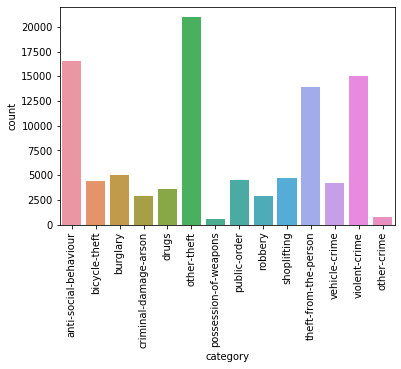

In [52]:
sns.countplot(data=crime_df,x='category')
plt.xticks(rotation=90)
plt.show()

**Severity of crimes**<br><br>
For types of crime, we have the option of either treating them as categorical variables or assign numerical values to them for further meaningful analysis. We chose the latter and assign weights to each crime category based on the severity index published by Office of National Statistics (ONS). For example, ONS assigns a severity of 800 for robbery (as a serious crime) while shopliffting gets severity index of 12 (less serious crime):<br>
https://www.ons.gov.uk/peoplepopulationandcommunity/crimeandjustice/datasets/crimeseverityscoreexperimentalstatistics

In [53]:
# Assign severity index values to each crime category

crime_df['crime_severity'] = crime_df['category'].map({'anti-social-behaviour': 5,'bicycle-theft': 15,
                                                       'burglary': 465, 'criminal-damage-arson': 442,
                                                       'drugs': 9, 'other-theft': 37,
                                                       'possession-of-weapons': 71, 'public-order': 73,
                                                       'robbery': 800, 'shoplifting': 12,
                                                       'theft-from-the-person': 80, 'vehicle-crime': 9,
                                                       'violent-crime': 1447, 'other-crime': 5})

**Seasonality of crimes**<br><br>
Using the index above and the number of reported cases, we could then assess the level of overall crime around Moorgate. We'll first see if there is a seasonality effect between the level of crime and month.

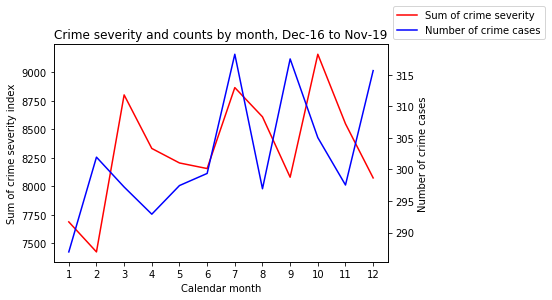

In [54]:
# Visualize the severity of crimes and number of crimes by month

crime_df['crime_month'] = pd.DatetimeIndex(crime_df['month']).month
crime_severity = crime_df.groupby('crime_month')['crime_severity'].count()
crime_count = crime_df.groupby('crime_month')['crime_severity'].mean()

fig, ax1 = plt.subplots()
ax1.plot(crime_severity, c='r', label='Sum of crime severity')
ax1.set_ylabel('Sum of crime severity index')
ax1.set_xlabel('Calendar month')
ax2 = ax1.twinx()
ax2.plot(crime_count, c='b', label='Number of crime cases')
ax2.set_ylabel('Number of crime cases')
ax2.set_title('Crime severity and counts by month, Dec-16 to Nov-19')
fig.legend(loc=3, bbox_to_anchor=(1,1), bbox_transform=ax2.transAxes)
plt.xticks(ticks=list(range(1,13)))
plt.show()

                        Plot-1
As we can see that the drop in number of crimes during certain months doesn't necessarily means that the severity of crime has decreased as well. In fact in months like March and October, drop in number of crimes has resulted in increase in severity of crimes.

**Status of crime investigation**<br><br>
There has also been concerns that convinction rates may not be as high as expected, an example of this is highlighted in the following news report: https://www.independent.co.uk/news/uk/crime/crime-statistics-uk-justice-prosecution-rates-rape-victims-disclosure-police-funding-a8747191.html
<br><br>
We wish to investigate the prevalence of where no suspect is identified for reported crimes. This would be particularly concerning for serious crimes where the suspect may still be at large.

In [55]:
# Top 10 investigation status and % of sample:

crime_df['outcome'].value_counts(normalize=True)[0:10]

Status update unavailable                        0.495841
Investigation complete; no suspect identified    0.288931
Under investigation                              0.099159
Unable to prosecute suspect                      0.020793
Court result unavailable                         0.019415
Local resolution                                 0.014369
Offender given a caution                         0.010942
Awaiting court outcome                           0.009971
Offender given a drugs possession warning        0.008761
Offender sent to prison                          0.005980
Name: outcome, dtype: float64

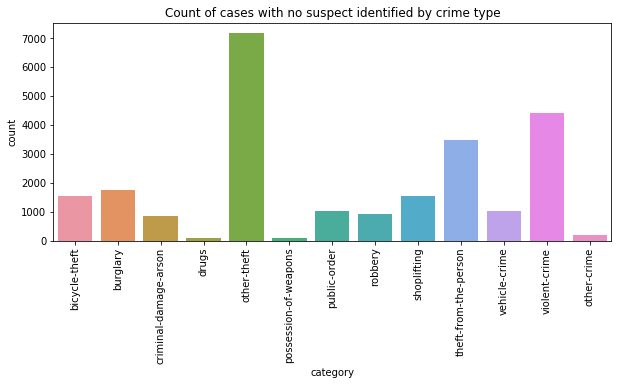

In [62]:
# Subset only cases where no suspect is identified (29% of our data)

no_suspect = crime_df[crime_df['outcome']=='Investigation complete; no suspect identified']

plt.figure(figsize=(10,4))
sns.countplot(no_suspect['category']).set_title('Count of cases with no suspect identified by crime type')
plt.xticks(rotation=90)
plt.show()

                                     Plot-2

**Stop and search by ethnicity**<br><br>
There has been news reports that certain ethnicities are more likely to be unjustifiably stopped for searching by the Police. Our second set of data contains ethnicity information wish we could explore. Futher information about concerns on racial profiling can be found here:
https://www.libertyhumanrights.org.uk/human-rights/justice-and-fair-trials/stop-and-search/stop-and-search-what-you-need-know

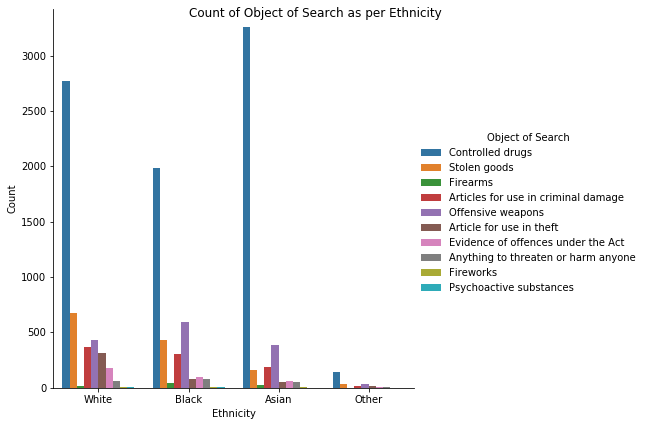

In [82]:
# Plot ethnicity information

g=sns.catplot(kind='count',data=stopsearch_df, x='officer_defined_ethnicity',
                   hue='object_of_search',legend_out=True,size=6)
g.set_axis_labels("Ethnicity", "Count")
g._legend.set_title('Object of Search')
g.fig.suptitle("Count of Object of Search as per Ethnicity")
plt.show()

                         Plot-3

As we can see from the graph, Asians are more likely to be stopped for controlled drugs and Whites for stolen goods. For offensive weapons, blacks are likely to be stopped more.

**Stop and search by age**<br><br>
As per the news reports, teenagers in Britain are more likely to have taken illegal drugs than youngsters anywhere else in Europe. Nearly 40% of teens are reported to have tried substances including cannabis and ecstasy. Our Analysis reflects the same as teens and youngsters in the age bracket of 18-24 are more likely to be stopped for controlled drugs.
https://www.dailymail.co.uk/news/article-24749/Britain-tops-teen-drugs-league.html

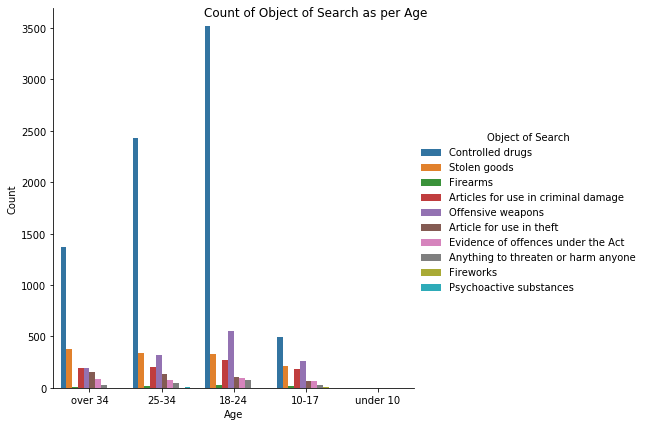

In [57]:
# Plot ethnicity information
g=sns.catplot(kind='count',data=stopsearch_df, x='age_range',
                   hue='object_of_search',legend_out=True,size=6)
g.set_axis_labels("Age", "Count")
g._legend.set_title('Object of Search')
g.fig.suptitle("Count of Object of Search as per Age")
plt.show()

## 4. Hypothesis tests

### Test 1: Is there a seasonality effect between crime level and month?

Plot-1 showing crime level vs. month shows that there appears to be more crimes in the warmer months of the year compared to the colder months. This potential seasonality effect can be explored more based the following subsetting of data:
- Temperature: does temperature affect crime rate around Moorgate? Jan being the coldest month and Jul being the warmest.

Our hypotheses are as follows:
- H0: There is no difference in the severity of criminal activities among different seasons
- H1: Season does affect the severity of criminal activities

The most suited test for our hypotheses would be **one-way Anova** :

In [84]:
# Categorize months based on season:

spring = [3,4,5]
summer = [6,7,8]
autumn = [9,10,11]
winter = [12,1,2]

d1 = list(crime_df[crime_df['crime_month'].isin(spring)]['crime_severity'])
d2 = list(crime_df[crime_df['crime_month'].isin(summer)]['crime_severity'])
d3 = list(crime_df[crime_df['crime_month'].isin(autumn)]['crime_severity'])
d4 = list(crime_df[crime_df['crime_month'].isin(winter)]['crime_severity'])

In [104]:
# Sampling for distribution plot

def sampling(df, seed_num, sample_num):
    output = []
    for i in range(seed_num):
        sample = df.sample(n=sample_num, random_state=i)
        output.append(sample.mean())
    return pd.DataFrame(output)

seed_num = 1000
sample_num = 2000

s1 = sampling(pd.DataFrame(d1), seed_num, sample_num)
s2 = sampling(pd.DataFrame(d2), seed_num, sample_num)
s3 = sampling(pd.DataFrame(d3), seed_num, sample_num)
s4 = sampling(pd.DataFrame(d4), seed_num, sample_num)

In [124]:
print(f'Mean: spring={round(s1.mean()[0],1)}, summer={round(s2.mean()[0],1)}, autumn={round(s3.mean()[0],1)}, winter={round(s4.mean()[0],1)}')

Mean: spring=296.2, summer=305.3, autumn=306.6, winter=301.7


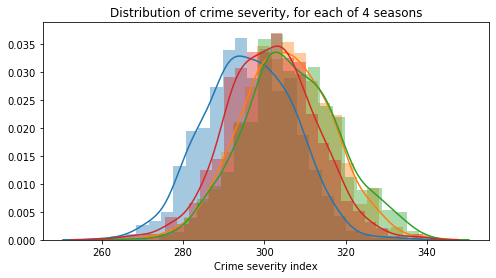

In [125]:
# Plot distribution of crime severity index

plt.figure(figsize=(8,4))
sns.distplot(s1)
sns.distplot(s2)
sns.distplot(s3).set_title('Distribution of crime severity, for each of 4 seasons')
sns.distplot(s4).set(xlabel='Crime severity index')
plt.show()

In [106]:
# Run one-way ANOVA test if sample means are statistically the same

f_oneway(d1,d2,d3,d4)

F_onewayResult(statistic=2.169319628630795, pvalue=0.08935620196776364)

##### As our p value from the ANOVA test is 0.089, we fail to reject the null hypothesis and hence, there is no significant statistical difference in the crime activity between different seasons.

### Test 2: Is the suspect for violent crimes less likely to be identified?

From the first bar chart shown earlier (Plot 2), we noted that violent crime comes only second after other thefts in terms of number of cases where the suspect is not identified after investigation is completed. We therefore want to investigate this further, to see if serious crimes have a lower rate of suspect identification compared to other crimes.
<br><br>
Our hypotheses are as follows:
- H0: Suspect of violent crimes are equally likely to be identified after investigation is completed as other crimes.
- H1: Suspect of violent crimes are less likely to be identified after investigation is completed.

In [59]:
investigation_complete = crime_df[crime_df['outcome'] != 'Status update unavailable']

In [60]:
# Define cut off points for crime severity index to be considered as serious:

mask1 = investigation_complete['crime_severity'] > 400   # i.e. arson and above
mask2 = investigation_complete['outcome'] =='Investigation complete; no suspect identified'

In [61]:
# Create subsets of 4 samples in chi-square test matrix:

a1 = len(investigation_complete[ mask1 &  mask2]) # Serious crimes, no suspect identified
a2 = len(investigation_complete[~mask1 &  mask2]) # Lesser crimes,  no suspect identified
a3 = len(investigation_complete[ mask1 & ~mask2]) # Serious crimes, other investigation outcomes
a4 = len(investigation_complete[~mask1 & ~mask2]) # Lesser crimes,  other investigation outcomes

serious_rate = a1/(a1+a3)
lesser_rate  = a2/(a2+a4)

print(f'Serious crimes with no suspect: {round(serious_rate*100,1)}%\nLess serious crimes with no suspect: {round(lesser_rate*100,1)}%')

f_obs = np.array([[a1,a2],[a3,a4]])
display(f_obs)

Serious crimes with no suspect: 56.3%
Less serious crimes with no suspect: 36.4%


array([[ 7943, 16166],
       [ 6161, 28298]])

In [62]:
# Run chi-square test:

chisquare(f_obs)

Power_divergenceResult(statistic=array([ 225.15059558, 3310.21554516]), pvalue=array([6.80714403e-51, 0.00000000e+00]))

**With p-value of pratically zero, we can conclude that it is statistically significant that the suspect for serious crimes is less likely to be identified compared to lesser crimes committed around Moorgate based on 2016-2019 data.**

### Test 3: Are ethnic minorities more likely to be stopped and searched?

From Plot 3 earlier we noted that the number of ethnic Asians that were stopped and searched was only slightly lower than ethnic white, although the proportion of ethnic white in the general population is far higher. We want to see if our data around Moorgate supports the claims from some organizations that ethnic minorities are more likely to be stopped and searched. Our hypotheses are as follows:
- H0: Ethnic minorities are not more likely to be stopped and searched than the general population
- H1: Ethnic minorities are more likely to be stopped and searched than the general population

The most suited test for our categorical data is the chi-squared in order to test if the prevalence of stop and search by ethnicity is significantly different from their overall demographic composition. The expected value is taken from 2011 UK National Census for London https://www.nomisweb.co.uk/census/2011/QS201EW/view/2013265927?cols=measures

In [63]:
# Observed % stop and search by ethnicity as assigned by the officer:

b1 = len(stopsearch_df[stopsearch_df['officer_defined_ethnicity']=='White'])/len(stopsearch_df)*100
b2 = len(stopsearch_df[stopsearch_df['officer_defined_ethnicity']=='Black'])/len(stopsearch_df)*100
b3 = len(stopsearch_df[stopsearch_df['officer_defined_ethnicity']=='Asian'])/len(stopsearch_df)*100
b4 = len(stopsearch_df[stopsearch_df['officer_defined_ethnicity']=='Mixed'])/len(stopsearch_df)*100
b5 = len(stopsearch_df[stopsearch_df['officer_defined_ethnicity']=='Other'])/len(stopsearch_df)*100

f_obs = np.array([b1,b2,b3,b4,b5])
f_obs.round(2)

array([36.79, 27.59, 31.79,  0.  ,  1.93])

In [64]:
# Demographics of City of London on the basis of 2011 census data. 

e1 = 59.79 # White
e2 = 13.32 # Black
e3 = 18.49 # Asian
e4 =  4.96 # Mixed
e5 =  3.44 # Other

f_exp = np.array([e1,e2,e3,e4,e5])
f_exp

array([59.79, 13.32, 18.49,  4.96,  3.44])

In [65]:
# Run chi-square test:

print('Based on ethnicity assigned by the officer:')
print(chisquare(f_obs,f_exp))

Based on ethnicity assigned by the officer:
Power_divergenceResult(statistic=39.31243248348811, pvalue=6.004329575810062e-08)


**With p-values very close to zero, we can conclude that it is statistically signifcant that ethnic minorities are more likely to be stopped and searched around Moorgate based on 2016-2019 data.**

## 5. Conclusion

1. **There is no conclusive seasonality effect between crime level and month**  
    - Our study defines crime level as the total number of crimes weighted by their severity index. By categorizing month into the four seasons, we could not find conclusive evidence that the crime rate is affected by any of these factors using one-way ANOVA test.
<br><br>
2. **Suspect for serious crimes is less likely to be identified than less serious crimes**   
    - Serious crimes are defined based on the severity index published ONS, which includes violent crimes, robbery, burgularly and arson. Using Chi-square test with equally likely outcome, we found that proportion of cases where a suspect is not found for serious crimes is statistically higher than lesser crimes.
<br><br>
3. **Ethnic minorities are more likely to be stopped and searched**  
    - Our data and tests support the claims made in the media that ethnic minorities are more likely to be stopped and searched on the street. For this hypothesis, we used Chi-square test where the expected outcome is based on UK census data for the demographic breakdown. We repeated the test using self-declared ethnicity and derived a similar conclusion.